In [1]:
%load_ext autoreload
%autoreload 2
import sys
import math

import numpy as np
import uncertainties
from uncertainties import unumpy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist
import hist.plot

sys.path.append("../..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from HistogramLib.iterative_fit import iterative_gaussian_fit
from hists.parameters import beamEnergies
from hists.store import HistogramId

In [2]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v42'
#clueParams = "single-file"
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data", "sim_proton_v46_patchMIP":"Simulation"}
PCAMethodToLegendMap = {"filterLayerSpan":"No LC selection", "filterLayerSpan_cleaned":"Cleaned"}

In [3]:
def getHist(beamEnergy, datatype, angleType:str, PCA_method:str="filterLayerSpan") -> hist.Hist:
    if angleType == "angle":
        histName = "Clus3DAnglePCAToImpact"
        plotAxis = "clus3D_angle_pca_impact"
    else:
        histName = "Clus3DAnglePCAToImpact_XY"
        if angleType == "angle_x":
            plotAxis = "clus3D_angle_pca_impact_x"
        elif angleType == "angle_y":
            plotAxis = "clus3D_angle_pca_impact_y"
        else:
            raise ValueError()
    
    return (histStore.get(HistogramId(histName, clueParams, datatype))
        .getHistogram(HistogramKind.COUNT)[{
            "beamEnergy":hist.loc(beamEnergy),
            "mainOrAllTracksters":hist.loc("mainTrackster"),
            "PCA_method":hist.loc(PCA_method),
            # project on clus3D_size
        }]
    .project(plotAxis)
    )

In [4]:
getHist(20, "data", "angle_x")#.axes[0].centers

Hist(Regular(200, -0.2, 0.2, name='clus3D_angle_pca_impact_x', label='Angle from PCA axis to DWC axis, projected in (Oxz) plane'), storage=Double()) # Sum: 19431.0 (19433.0 with flow)

In [5]:
def mpv(h:hist.Hist):
    return h.axes[0].centers[np.argmax(h.counts())]

In [6]:
def countHistogramToWeightHistogram(h:hist.Hist):
    """ Transform a count boost.histogram (ie Double storage type) to a Weight storage histogram, with weights=1 """
    w_h = hist.Hist(*h.axes, storage=hist.storage.Weight())
    w_h.view(flow=True).value, w_h.view(flow=True).variance = h.view(flow=True), h.view(flow=True)
    return w_h

def addLumiLegend(main_ax, datatypes, beamEnergies):
    if "data" in datatypes:
        hep.cms.text("Preliminary", ax=main_ax)
    else:
        hep.cms.text("Simulation Preliminary", ax=main_ax)
    if isinstance(beamEnergies, list):
        hep.cms.lumitext(f"$e^+$ test beam", ax=main_ax)
    else:
        hep.cms.lumitext(f"$e^+$ {str(beamEnergies)} GeV", ax=main_ax)
    main_ax.legend()

def plot(beamEnergies, datatypes, angleType:str, PCAMethod:str="filterLayerSpan", log=False, ax=None, rebin=None, fit=False, xlim=None):
    ylabel = "Event count"
    if isinstance(PCAMethod, list):
        hists = [getHist(beamEnergies, datatypes, angleType=angleType, PCA_method=PCA_method_i) for PCA_method_i in PCAMethod]
        labels = [PCAMethodToLegendMap[i] for i in PCAMethod]
    elif isinstance(datatypes, list):
        hists = [getHist(beamEnergies, datatype, angleType=angleType, PCA_method=PCAMethod) for datatype in datatypes]
        for i in range(len(datatypes)):
            if i == 0:
                count_data = hists[0].sum(flow=True)
            else:
                hists[i] = countHistogramToWeightHistogram(hists[i]) * (count_data / hists[i].sum(flow=True))
        labels = [datatypeToLegendMap[datatype] for datatype in datatypes]
    elif isinstance(beamEnergies, list):
        hists = [getHist(beamEnergy, datatypes, angleType=angleType, PCA_method=PCAMethod) for beamEnergy in beamEnergies]
        for i in range(len(beamEnergies)):
            if i == 0:
                count_first = hists[0].sum(flow=True)
            else:
                hists[i] = countHistogramToWeightHistogram(hists[i]) * (count_first / hists[i].sum(flow=True))
        labels = [f"{beamEnergy} GeV" for beamEnergy in beamEnergies]
        ylabel = "Event count (normalized)"
    else:
        hists = [getHist(beamEnergies, datatypes, angleType=angleType, PCA_method=PCAMethod)]
        labels = [""]
    if rebin is not None:
        hists = [h[::hist.rebin(rebin)] for h in hists]

    for i, (h, label) in enumerate(zip(hists, labels)):
        mpv_cur = mpv(h)
        labels[i] = label + f" - MPV={mpv_cur*100:.2g} mrad ({math.degrees(mpv_cur):.2g}°)"

    if ax is None:
        fig, ax = plt.subplots()

    if fit:
        assert(len(hists) == 1)
        hists[0].plot_pull("gaus", likelihood=True)
    else:
        hep.histplot(hists, yerr=False, label=labels, ax=ax)

    if log:
        ax.set_yscale("log")
    
    if angleType == "angle":
        if log:
            ax.set_xlim(0, 0.25)
        else:
            ax.set_xlim(0, 0.1)
        ax.set_xlabel("Angle between PCA axis and DWC track (radians)")
    else:
        if log:
            ax.set_xlim(-0.2, 0.2)
        else:
            ax.set_xlim(-0.1, 0.1)
        if angleType == "angle_x":
            axis = "x"
        elif angleType == "angle_y":
            axis = "y"
        else:
            raise ValueError()
        ax.set_xlabel(f"Angle between the projections on (O{axis}z) plane\nof the PCA axis and DWC track (radians)")
    
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.set_ylabel(ylabel)

    addLumiLegend(ax, datatypes, beamEnergies)

    

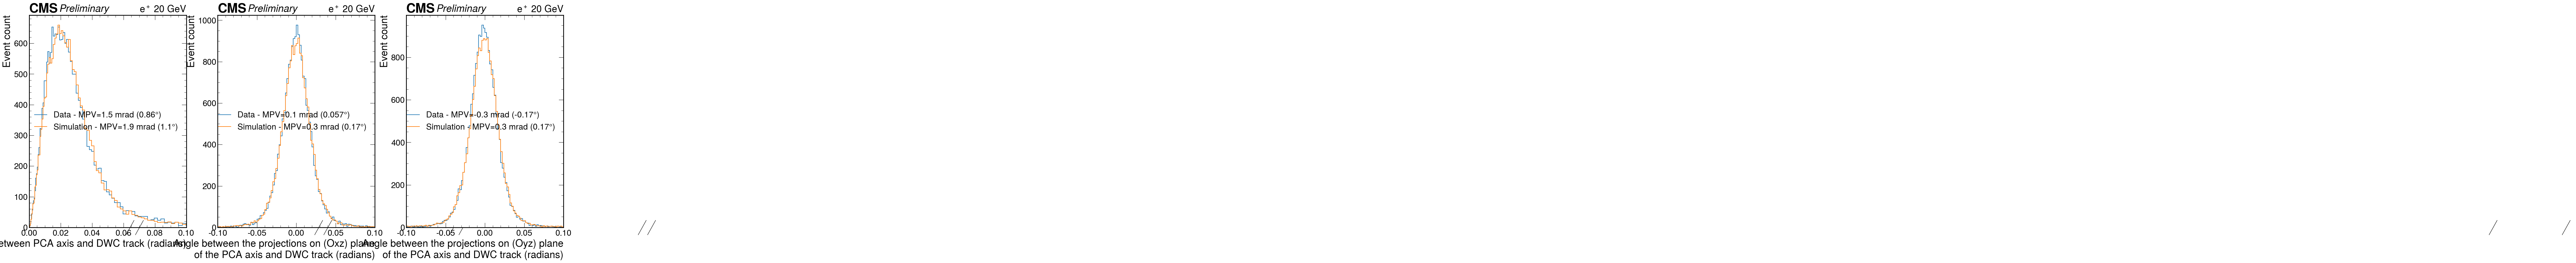

In [7]:
beamEnergy = 20
fig, (angle, angle_x, angle_y) = plt.subplots(1, 3, figsize=(25, 10))
plot(beamEnergy, ["data", "sim_proton_v46_patchMIP"], angleType="angle", ax=angle, rebin=3)
plot(beamEnergy, ["data", "sim_proton_v46_patchMIP"], angleType="angle_x", ax=angle_x)
plot(beamEnergy, ["data", "sim_proton_v46_patchMIP"], angleType="angle_y", ax=angle_y)

## Compare data/sim

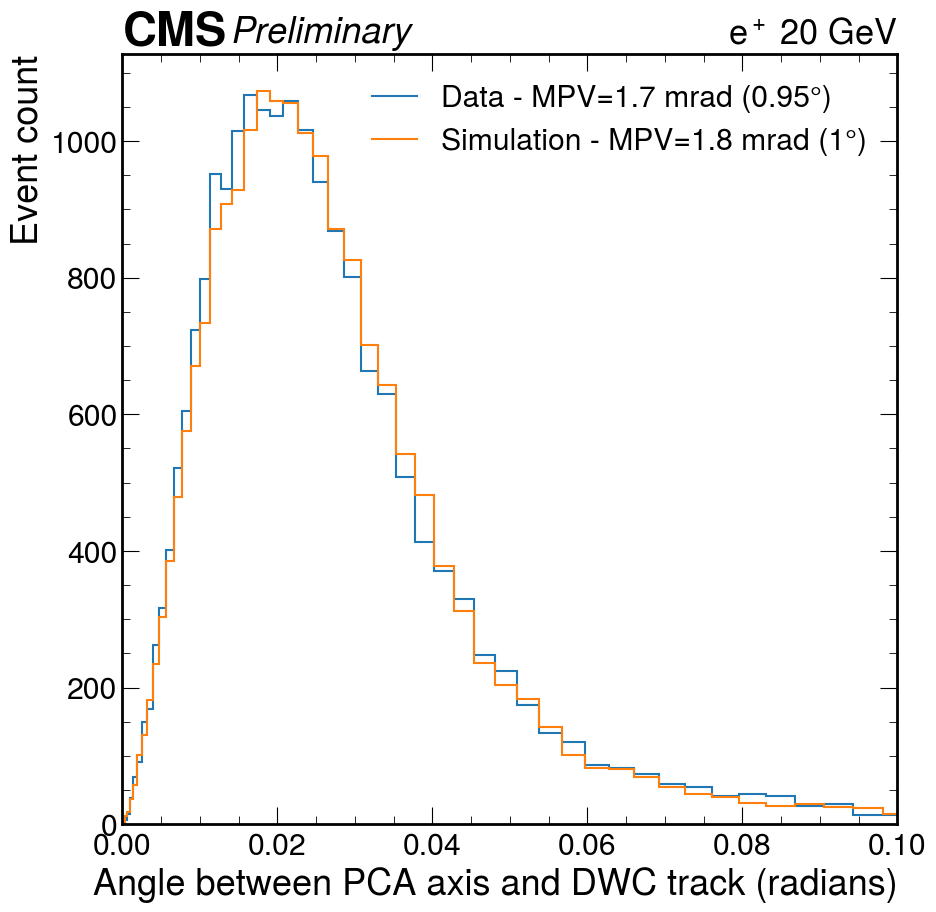

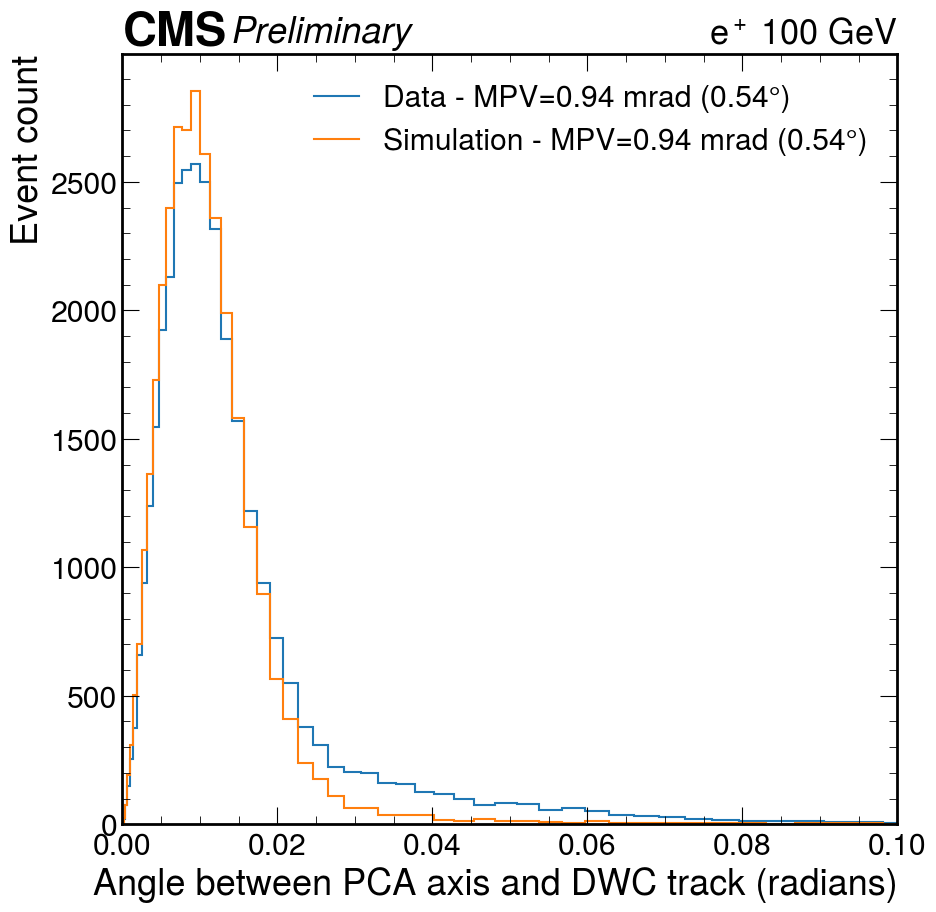

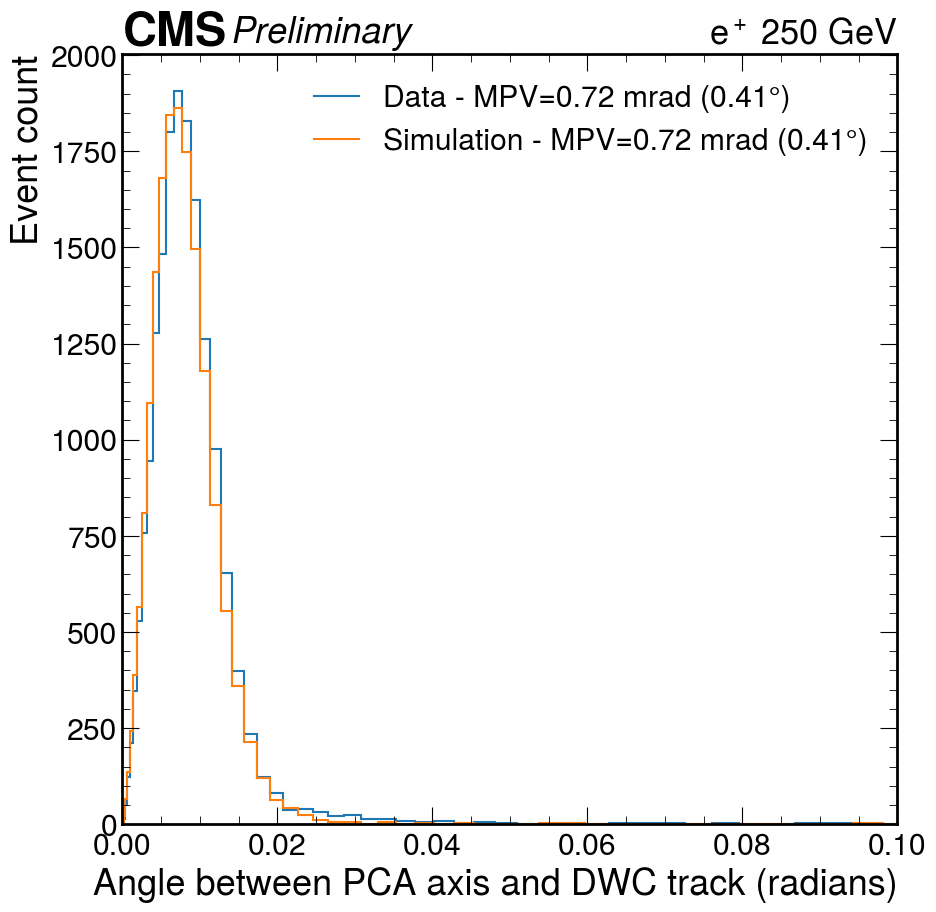

In [17]:
kwargs = dict(angleType = "angle", rebin = 5)
plot(20, ["data", "sim_proton_v46_patchMIP"], **kwargs)
plot(100, ["data", "sim_proton_v46_patchMIP"], **kwargs)
plt.savefig("../plots/pca-angle-100.pdf", bbox_inches="tight")
plot(250, ["data", "sim_proton_v46_patchMIP"], **kwargs)

## Compare cleaned/not cleaned

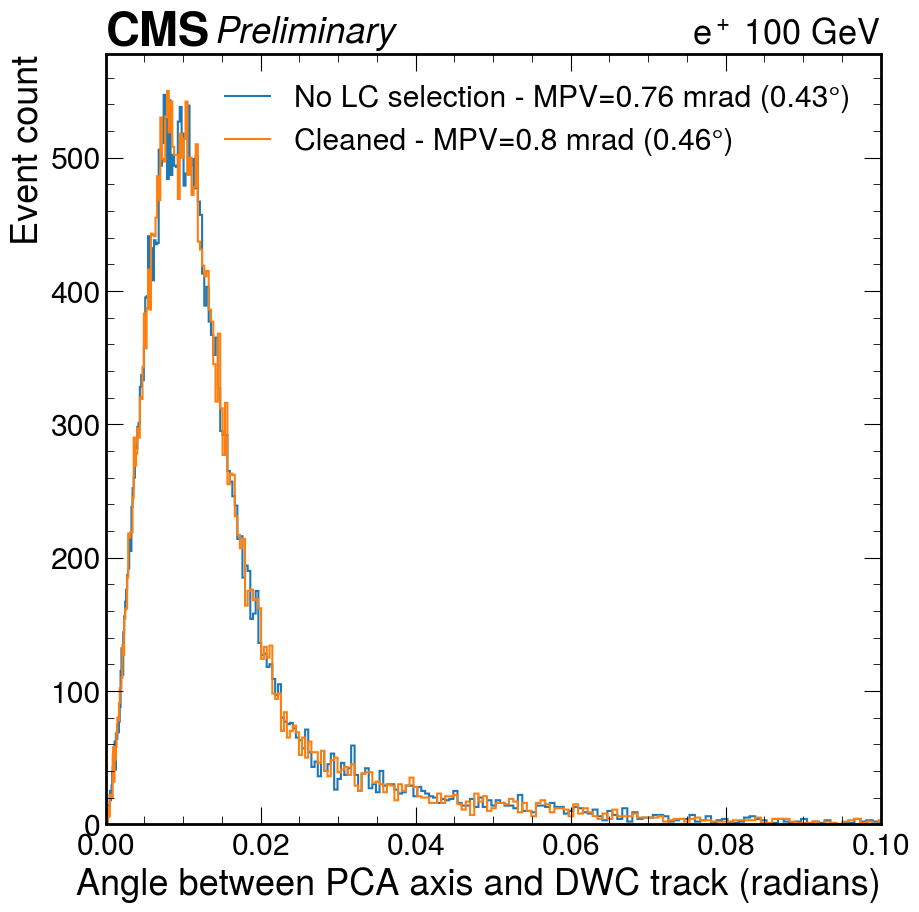

In [9]:
plot(100, "data", angleType="angle", PCAMethod=["filterLayerSpan", "filterLayerSpan_cleaned"])

## Compare beam energies

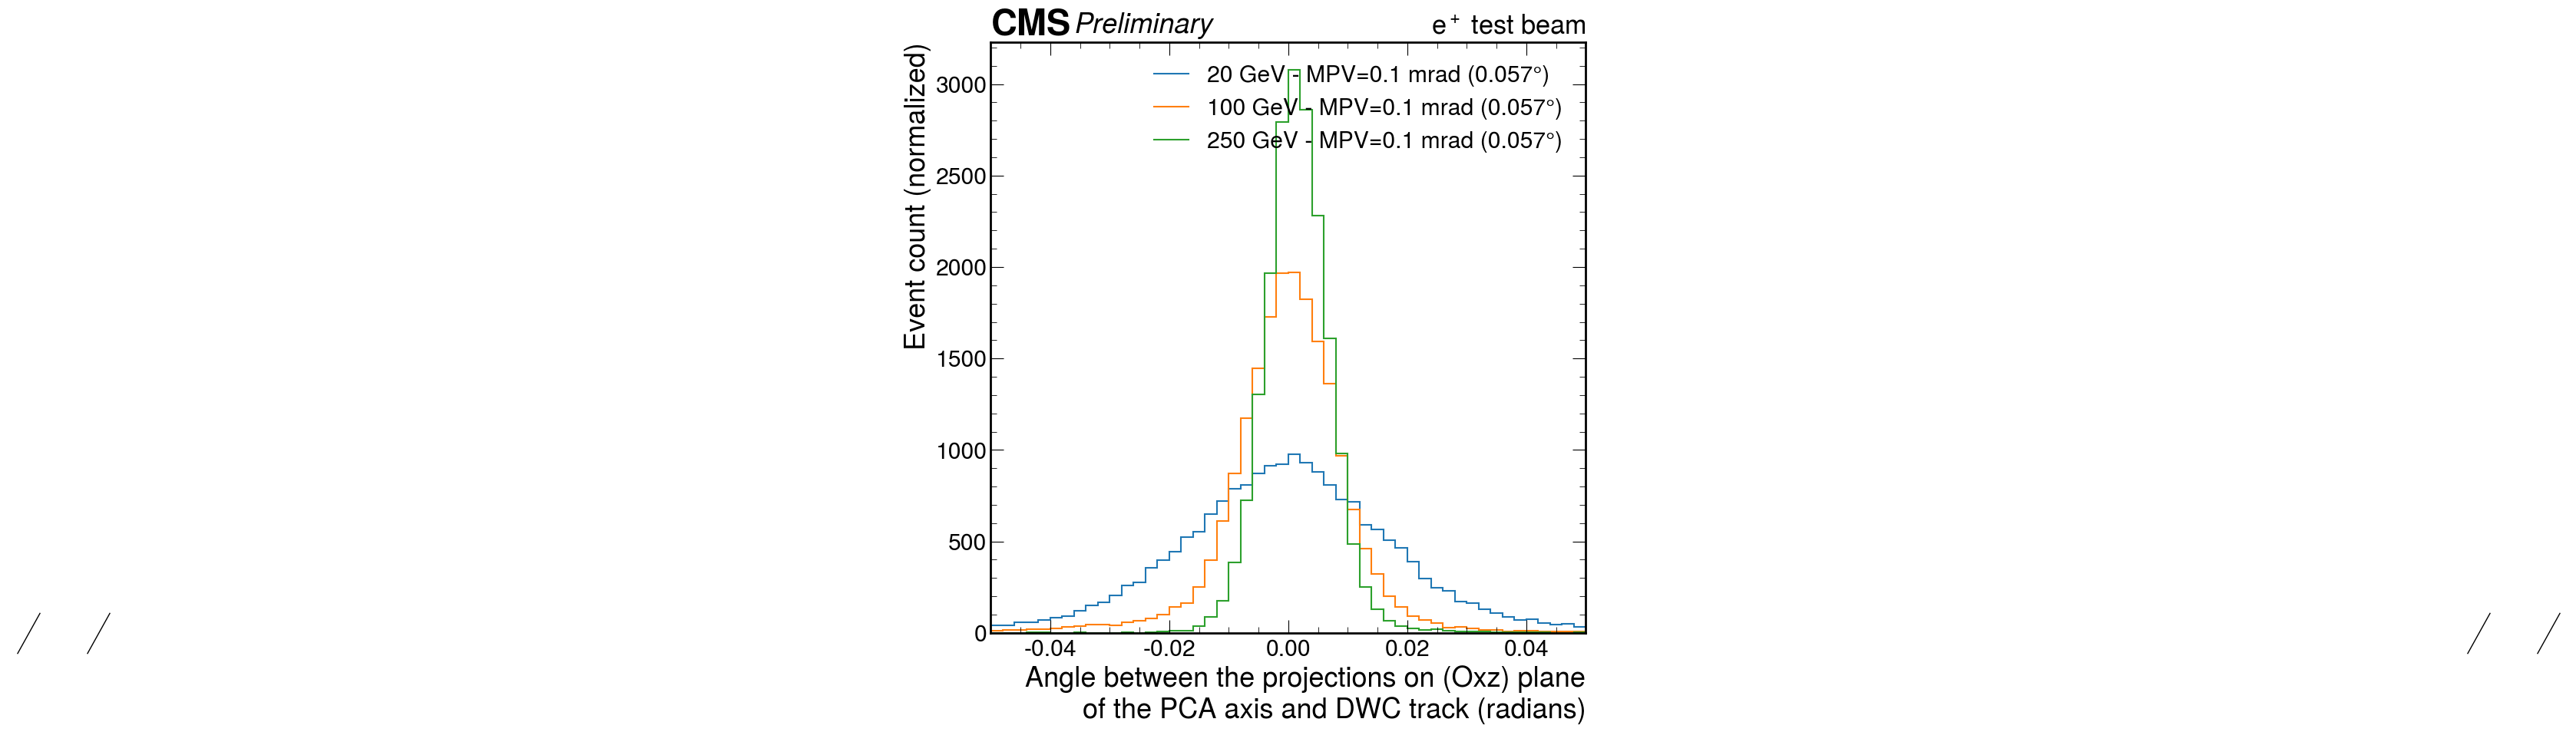

In [10]:
plot([20, 100, 250], "data", angleType="angle_x", xlim=(-0.05, 0.05))

## Fitting
Really does not like fitting to Gaussians

In [11]:
def sigmaMuFctBeamEnergy(datatype, angleType):
    x = []
    means = []
    sigmas = []
    for beamEnergy in beamEnergies:
        h = getHist(beamEnergy, datatype, angleType)
        try:
            window, (norm, mean, sigma), errorMode = iterative_gaussian_fit(h, startWindow=(-0.06, 0.06), sigmaRange=(-2, 2), minSigma=0.002)
            if errorMode != "hesse":
                raise RuntimeError(norm, mean, sigma, errorMode)
            x.append(beamEnergy)
            means.append(mean)
            sigmas.append(sigma)
            
        except Exception as e:
            print(e)
    
    return dict(x=x, y=unumpy.nominal_values(sigmas), yerr=unumpy.std_devs(sigmas))

def plotSigmaFctBeamEnergy(datatypes, angleType):
    fig, ax = plt.subplots()
    for datatype in datatypes:
        ax.errorbar(**sigmaMuFctBeamEnergy(datatype, angleType), label=datatype)

    ax.set_xlabel("Beam energy (GeV)")
    ax.set_ylabel("Fitted sigma (radians)")
    addLumiLegend(ax, datatypes, beamEnergies)
    ax.legend()

begin < end required


/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis/lib/python3.10/site-packages/uncertainties/core.py:188: RuntimeWarning: invalid value encountered in divide
  covariance_mat/norm_vector/norm_vector[:,numpy.newaxis],


(3167.0+/-inf, -0.0001618833360115715+/-inf, 0.00011244208882007108+/-inf, 'curve_fit+sigmaAtBoundary')
(2871.0+/-inf, 0.001775451911698697+/-inf, 5.889710335292278e-05+/-inf, 'curve_fit+sigmaAtBoundary')


/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis/lib/python3.10/site-packages/uncertainties/core.py:188: RuntimeWarning: invalid value encountered in divide
  covariance_mat/norm_vector/norm_vector[:,numpy.newaxis],


(2377.0+/-inf, 0.0018074505238649579+/-inf, 3.958131818003176e-05+/-inf, 'curve_fit+sigmaAtBoundary')
(2670.0+/-inf, 0.0015626483151400083+/-inf, 3.3927850224205766e-05+/-inf, 'curve_fit+sigmaAtBoundary')


/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis/lib/python3.10/site-packages/uncertainties/core.py:188: RuntimeWarning: invalid value encountered in divide
  covariance_mat/norm_vector/norm_vector[:,numpy.newaxis],


(3634.0+/-inf, -0.0003876923921095243+/-inf, 8.159243103533983e-05+/-inf, 'curve_fit+sigmaAtBoundary')
(3713.0+/-inf, -4.646043332174873e-05+/-inf, 6.73060328312175e-05+/-inf, 'curve_fit+sigmaAtBoundary')
(3535.0+/-inf, 0.0002680487882551496+/-inf, 5.791385093943688e-05+/-inf, 'curve_fit+sigmaAtBoundary')
(3743.0+/-inf, 0.00036685670360642983+/-inf, 4.8639165438373355e-05+/-inf, 'curve_fit+sigmaAtBoundary')
(170693.14498452772+/-inf, 0.0008423834246502288+/-inf, 5.675772516685567e-05+/-inf, 'curve_fit+sigmaAtBoundary')


/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis/lib/python3.10/site-packages/uncertainties/core.py:188: RuntimeWarning: invalid value encountered in divide
  covariance_mat/norm_vector/norm_vector[:,numpy.newaxis],


(5453.0+/-inf, 0.00029133938590227324+/-inf, 3.2617661400985734e-05+/-inf, 'curve_fit+sigmaAtBoundary')


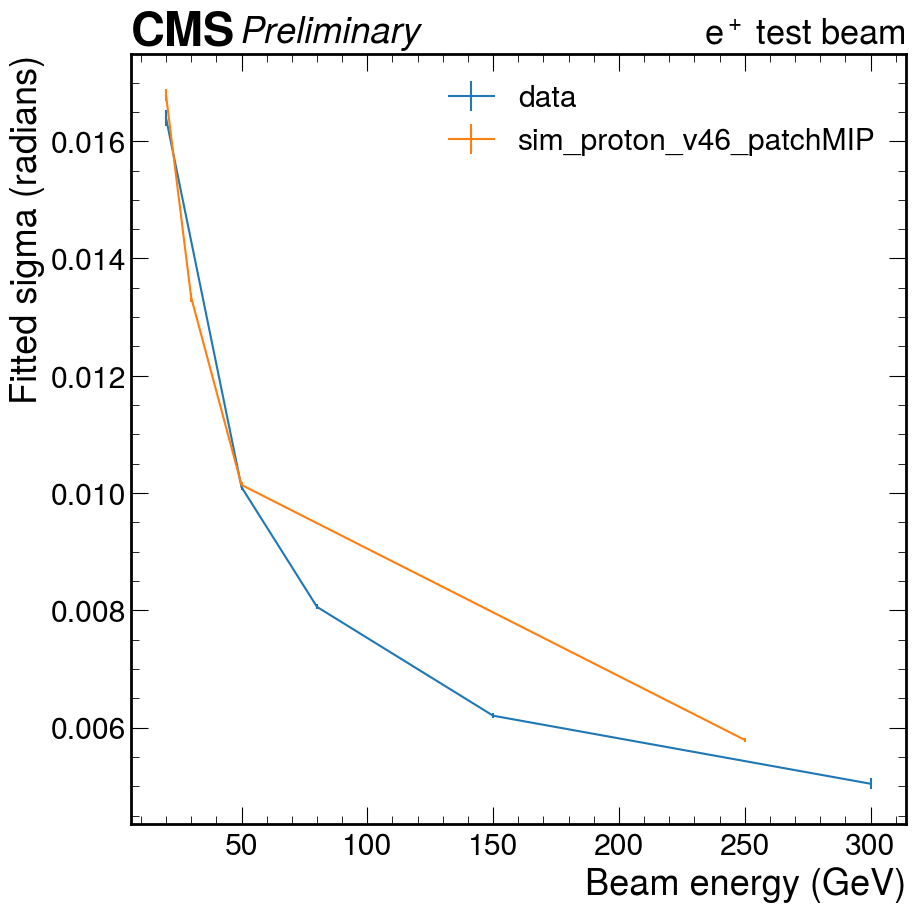

In [12]:
plotSigmaFctBeamEnergy(["data", "sim_proton_v46_patchMIP"], "angle_x")

## Using quantiles

In [13]:
def quantileHist(h:hist.Hist, q):
    return np.quantile(h.view(flow=False))